In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

# Importing modelling libraries
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

from factor_analyzer import FactorAnalyzer

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 999)


In [119]:
train_data = pd.read_csv('train.csv')
print(train_data.shape)
train_data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Manually Remove Unnecessary columns

In [120]:
#Set Index
train_data.set_index('PassengerId', inplace=True)
#Manually Remove Columns
train_data.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# Handling mixed data types

In [121]:
Numerical_columns= train_data.select_dtypes(include=['int','float']).columns
Categorical_columns= train_data.select_dtypes(include=['object']).columns

**Handle Mixed Data types of numerical columns**

In [122]:
def handle_mixed_dtypes_for_num(value):
    try:
        value = int(value)
    except:
        value = np.nan
    return value

In [123]:
for num_cols in list(Numerical_columns):
    train_data[num_cols] = train_data[num_cols].apply(lambda x: handle_mixed_dtypes_for_num(x))

**Handle Mixed Data types of Categorical columns**

In [124]:
for cat_cols in list(Categorical_columns):
    print(cat_cols,':->',train_data[cat_cols].unique())

Sex :-> ['male' 'female']
Embarked :-> ['S' 'C' 'Q' nan]


In [125]:
val=['male' ,'female']
train_data["Sex"] = train_data['Sex'].apply(lambda x: x if x in val   else np.nan)

val=['S', 'C' ,'Q']
train_data["Embarked"] = train_data['Embarked'].apply(lambda x: x if x in val   else np.nan)

# Convert columns to correct format (date column)

# Handling missing values.

In [126]:
train_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

<AxesSubplot:ylabel='PassengerId'>

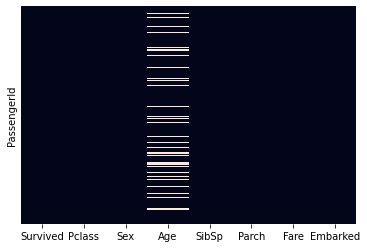

In [127]:
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False)

In [128]:
def get_null_values_df(train_data):
    null_df = pd.DataFrame({'col_name':((train_data.isna().sum()/len(train_data))*100).index,
                        'null_percent':((train_data.isna().sum()/len(train_data))*100).values}) \
                        .sort_values(by=['null_percent'], ascending=False)
    return null_df

null_df = get_null_values_df(train_data)
null_df.head(10)

,col_name,null_percent
3,Age,19.865320
7,Embarked,0.224467
0,Survived,0.000000
1,Pclass,0.000000
2,Sex,0.000000
4,SibSp,0.000000
5,Parch,0.000000
6,Fare,0.000000


**Remove columns which has more than 30% null values**

In [129]:
drop_cols = null_df[null_df.null_percent > 30]['col_name'].values
drop_cols

array([], dtype=object)

In [130]:
train_data.drop(drop_cols, axis=1, inplace=True)

In [131]:
train_data['Age']=train_data['Age'].fillna(train_data['Age'].mean())
train_data['Embarked']=train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
#train_data.drop(['Alley'],axis=1,inplace=True)
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

**Handling duplicates**

In [132]:
print('Number of rows with duplicates:',train_data.shape[0])
train_data.drop_duplicates(keep=False, inplace=True)
print('Number of rows without duplicates:',train_data.shape[0])

Number of rows with duplicates: 891
Number of rows without duplicates: 618


# Handling outliers

In [133]:
# Dropping the outlier rows with standard deviation
print('Number of rows with outliers: ',train_data.shape[0])

for NUM_cols in Numerical_columns:
    factor = 3
    upper_lim = train_data[NUM_cols].mean () + train_data[NUM_cols].std () * factor
    lower_lim = train_data[NUM_cols].mean () - train_data[NUM_cols].std () * factor

    train_Outlier_Removed = train_data[(train_data[NUM_cols] < upper_lim) & (train_data[NUM_cols] > lower_lim)]
print('Number of rows without outliers: ',train_Outlier_Removed.shape[0])

Number of rows with outliers:  618
Number of rows without outliers:  602


# Exploratory Data Analysis

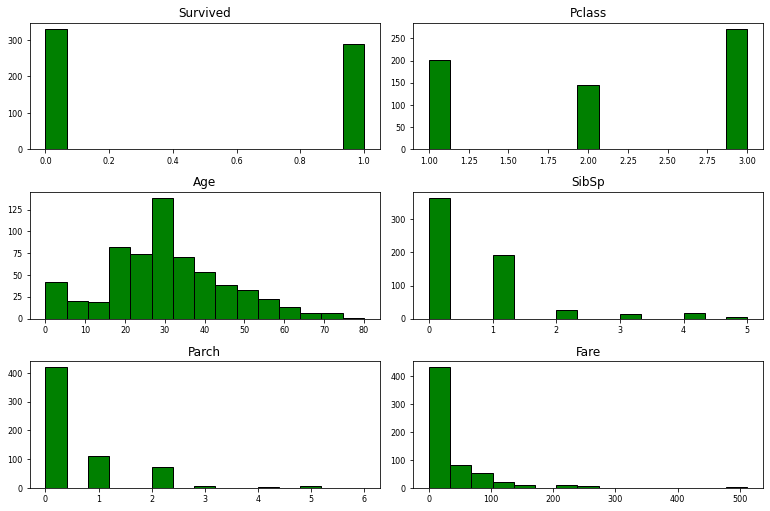

In [137]:
train_data.iloc[:,:].hist(bins=15, color='green', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)

# command to give space b/t diff. plots 
plt.tight_layout(rect=(0, 0, 1.8, 1.8))  

C:\Users\ASLAM_~1\AppData\Local\Temp/ipykernel_15256/4228299314.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\ASLAM_~1\AppData\Local\Temp/ipykernel_15256/4228299314.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



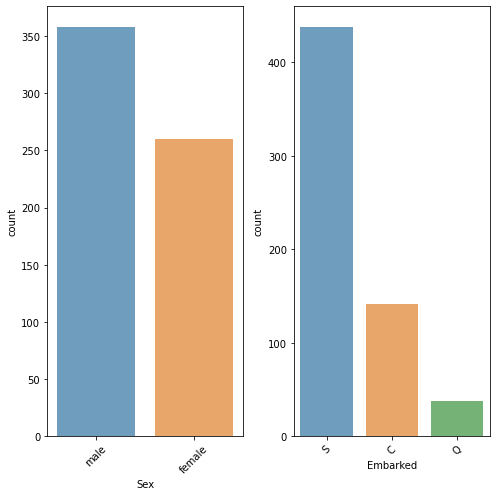

In [145]:
fig, axes = plt.subplots(round(len(Categorical_columns) / 2), 2, figsize=(7, 7))

for i, ax in enumerate(fig.axes):
    if i < len(Categorical_columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=Categorical_columns[i], alpha=0.7, data=train_data, ax=ax)

fig.tight_layout()

# Handling imbalanced data (Classification problem)

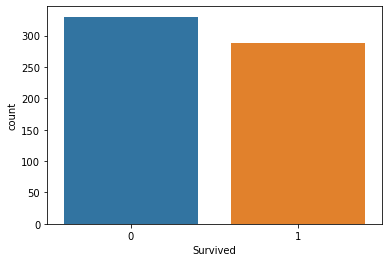

In [136]:
ax=sns.countplot(x='Survived',data=train_data)

In [ ]:
## use Random over sampler
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler(1)
X_Rres,Y_Rres=os.fit_resample(X_train,y_train)
print(X_Rres.shape,Y_Rres.shape)